In [1]:
import time
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import download, viz


In [2]:
url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.rec'
idx_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.idx'
download(url, path='../data/pikachu/pikachu_train.rec', overwrite=False)
download(idx_url, path='../data/pikachu/pikachu_train.idx', overwrite=False)


85605KB [00:12, 7090.05KB/s]                           
12KB [00:00, 4009.85KB/s]             


'../data/pikachu/pikachu_train.idx'

label:  [[309.6292  205.79944 355.75494 274.14044   0.     ]]


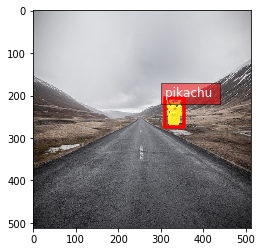

In [3]:
dataset = gcv.data.RecordFileDetection('../data/pikachu/pikachu_train.rec')
classes = ['pikachu']
image, label = dataset[0]
print("label: ", label)
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.show()


In [4]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained=True)
net.reset_class(classes)
def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
    width, height = data_shape, data_shape
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
        # anchors: (1, N, 4): N 为 图片中anchors的数量
    batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    train_loader = gluon.data.DataLoader(train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
                                         batch_size,
                                         shuffle=True,
                                         batchify_fn=batchify_fn,
                                         last_batch='rollover',
                                         num_workers=num_workers)
    return train_loader

train_data = get_dataloader(net, dataset, 512, 16, 0)



d:\software_setup\python37\lib\site-packages\mxnet\gluon\block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]
50217KB [00:07, 6406.01KB/s]                           


Model file is not found. Downloading.


In [8]:
from mxnet import nd
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = [mx.gpu(0)]
except:
    ctx = [mx.cpu()]
    
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})
mbox_loss = gcv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')  # 记录cls 的loss
smoothl1_metric = mx.metric.Loss('SmoothL1')  # 记录box 偏移量的loss


In [ ]:
for epoch in range(2):
    ce_metric.reset()
    smoothl1_metric.reset()
    net.hybridize(static_alloc=True, static_shape=True)
    btic = time.time()
    
    for ib, batch in enumerate(train_data):
        batch_size = batch[0].shape[0]
        data = gcv.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        data = nd.array(data)
        cls_targets = gcv.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        cls_targets = nd.array(cls_targets)
        box_targets = gcv.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
        box_targets = nd.array(box_targets)
        with autograd.record():
            cls_preds, box_preds, _ = net(data)
            sum_loss, cls_loss, box_loss = mbox_loss(cls_preds, box_preds, cls_targets, box_targets)
        sum_loss.backward()
        trainer.step(1)
        
        ce_metric.update(0, [l * batch_size for l in cls_loss])
        
        smoothl1_metric.update(0, [l * batch_size for l in box_loss])
        
        if ib % 10 == 0:
            name1, loss1 = ce_metric.get()
            name2, loss2 = smoothl1_metric.get()
            print("[Epoch {} Batch {}] speed {:.3f} samples/sec  {}={:.3f}  {}={:.3f}".format(
                epoch, ib, batch_size/time.time() - btic, name1, loss1, name2, loss2))
        
        btic = time.time()


In [ ]:
net.save_parameters('ssd_512_mobilenet1.0_pikachu.params')
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_voc', classes=classes, pretrained_base=False)
net.load_parameters('ssd_512_mobilenet1.0_pikachu.params')
x, image = gcv.data.transforms.presets.ssd.load_test('../img/pikachu_test.jpg', 512)
cid, score, bbox = net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes)
plt.show()